In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def read_ppm(filename):
    with open(filename, 'rb') as f:
        header = f.readline().decode().strip()
        if header not in ['P5', 'P6']:
            raise ValueError('Not a PPM file')
        width, height = map(int, f.readline().decode().strip().split())
        maxval = int(f.readline().decode().strip())
        if header == 'P6':
            data = np.fromfile(f, dtype=np.uint8).reshape((height, width, 3))
        else:  # P5
            data = np.fromfile(f, dtype=np.uint8).reshape((height, width))
    return data

In [4]:
def write_ppm(filename, img):
    if len(img.shape) == 3:
        height, width, _ = img.shape
        header = b'P6\n'
    else:
        height, width = img.shape
        header = b'P5\n'

    with open(filename, 'wb') as f:
        f.write(header)
        f.write(f'{width} {height}\n255\n'.encode())
        img.tofile(f)

In [5]:
def rgb_to_grayscale_ppm(input_filename, output_filename):
    rgb_img = read_ppm(input_filename)
    grayscale_img = np.mean(rgb_img, axis=2).astype(np.uint8)
    write_ppm(output_filename, grayscale_img)

In [6]:
def normalize(img):
    result = img.astype(np.float32)
    result -= result.min()
    result *= 255.0 / result.max()
    result = result.astype(np.uint8)
    return result

In [7]:
def display_images(images, titles):
    plt.figure(figsize=(16, 16))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [8]:
#rgb_to_grayscale_ppm('./sample.ppm', './grayscale-sample.ppm')
#rgb_to_grayscale_ppm('./lena.ppm', './grayscale-lena.ppm')
#rgb_to_grayscale_ppm('./dwsample.ppm', './grayscale-dwsample.ppm')

# Questao 1

Implemente uma funcao que receba uma imagem em formato PPM, o tamanho n de um filtro espacial com dimensoes n × n e a matriz com os pesos do filtro, e aplique o filtro com uma convolucao, gerando e salvando a imagem resultante no disco em formato PPM. Voce nao pode usar a OpenCV em nenhum desses passos. As especificacoes do formato PPM podem ser encontradas aqui: https://netpbm.sourceforge.net/doc/ppm.html

In [9]:
# resposta da questao 1:

def apply_filter_to_color_image(img, filter):
    height, width = img.shape[:2]
    filter_size = filter.shape[0]
    
    pad_size = filter_size // 2
    #padded_img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
    padded_img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='edge')
    
    result = np.empty_like(img)
    for i in range(height):
        for j in range(width):
            for k in range(3):
                result[i, j, k] = np.sum(filter * padded_img[i:i+filter_size, j:j+filter_size, k])
                    
    return normalize(result)

def apply_filter_to_grayscale_image(img, filter):
    height, width = img.shape[:2]
    filter_size = filter.shape[0]
    
    pad_size = filter_size // 2
    padded_img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size)), mode='edge')
    
    result = np.empty_like(img)
    for i in range(height):
        for j in range(width):
            result[i, j] = np.sum(filter * padded_img[i:i+filter_size, j:j+filter_size])
    
    return normalize(result)

def apply_filter(img, filter):
    if len(img.shape) == 3:  # Imagem colorida
        return apply_filter_to_color_image(img, filter)
    else:  # Imagem em escala de cinza
        return apply_filter_to_grayscale_image(img, filter)

In [27]:
def apply_filters(img, filters):
    filtered_imgs = []
    for name, filter in filters.items():
        filtered_img = apply_filter(img, filter)
        filtered_imgs.append(filtered_img)
    return filtered_imgs

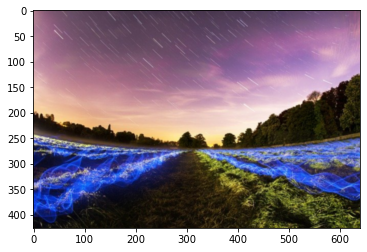

In [11]:
img = read_ppm('./sample.ppm')
filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16  # Filtro de suavização Gaussiano 3x3
filtered_img = apply_filter(img, filter)
plt.imshow(filtered_img)
plt.show()

# Questao 2

Usando a funcao da questao 1, pesquise um filtro passa-alta e aplique-o em 3 imagens distintas, variando o valor de n em 3 unidades em cada imagem. O que acontece quando n cresce?

In [12]:
filtro_passa_alta_3x3 = np.array([[-1, -1, -1],
                                  [-1,  8, -1],
                                  [-1, -1, -1]])

filtro_passa_alta_6x6 = np.ones((6, 6)) * -1
filtro_passa_alta_6x6[2:4, 2:4] = 8

filtro_passa_alta_9x9 = np.ones((9, 9)) * -1
filtro_passa_alta_9x9[3:6, 3:6] = 8

## !!! Problema aq, provavelmente por conta de valores negativos !!!

In [28]:
img = read_ppm('./sample.ppm')

filters = {"filtro_passa_alta_3x3": filtro_passa_alta_3x3,
           "filtro_passa_alta_6x6": filtro_passa_alta_6x6,
           "filtro_passa_alta_9x9": filtro_passa_alta_9x9}

imgs = apply_filters(img, filters, './Outputs/OutputQ2')
display_images(imgs, ['filtro_passa_alta_3x3', 'filtro_passa_alta_6x6', 'filtro_passa_alta_9x9'])

TypeError: apply_filters() takes 2 positional arguments but 3 were given

R:

Quanto maior o filtro, mais pixels vizinhos ele considera, e mais ele começará a realçar detalhes de maior escala na imagem, realçando também bordas e detalhes finos.

# Questao 3

Usando a funcao da questao 1, pesquise um filtro passa-baixa e aplique-o em 3 imagens distintas, variando o valor de n em 3 unidades em cada imagem. O que acontece quando n cresce?

In [14]:
filtro_passa_baixa_3x3 = np.ones((3, 3)) / 9
filtro_passa_baixa_6x6 = np.ones((6, 6)) / 36
filtro_passa_baixa_9x9 = np.ones((9, 9)) / 81

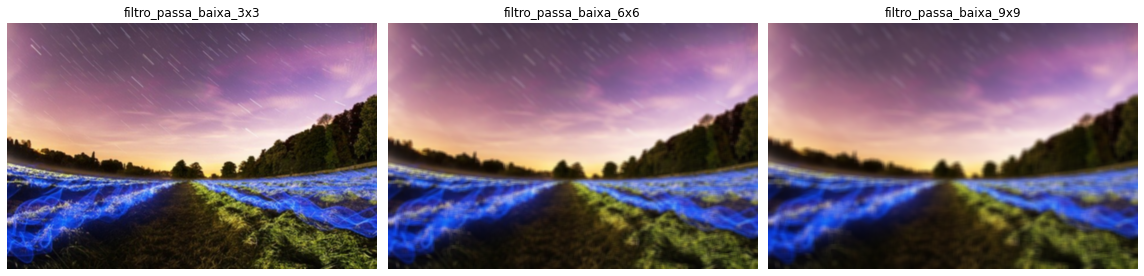

In [15]:
img = read_ppm('./sample.ppm')

filters = {"filtro_passa_baixa_3x3": filtro_passa_baixa_3x3,
           "filtro_passa_baixa_6x6": filtro_passa_baixa_6x6,
           "filtro_passa_baixa_9x9": filtro_passa_baixa_9x9}

imgs = apply_filters(img, filters, './Outputs/OutputQ3')
display_images(imgs, ['filtro_passa_baixa_3x3', 'filtro_passa_baixa_6x6', 'filtro_passa_baixa_9x9'])

R:

Quanto maior o filtro, mais pixels vizinhos ele considera, e mais ele começará a suavizar detalhes de maior escala na imagem, suavizando também detalhes finos.

# Questao 4

Um filtro passa-baixa bastante conhecido e o filtro Gaussiano. Atraves de uma mascara determinada por um desvio padrao σ, e possıvel fazer o que chamamos de suavizacao gaussiana de uma imagem. Considere o filtro 5x5 de desvio padrao unitario abaixo:

g =

1/273 4/273 7/273 4/273 1/273

4/273 16/273 26/273 16/273 4/273

7/273 26/273 41/273 26/273 7/273

4/273 16/273 26/273 16/273 4/273

1/273 4/273 7/273 4/273 1/273

Crie uma imagem I de dimensoes 100 × 100 que contem um unico valor nao nulo localizado no centro da imagem. Utilizando o filtro gaussiano acima, calcule e exiba I ∗ g, onde ∗ e a notacao para o operador de convolucao.

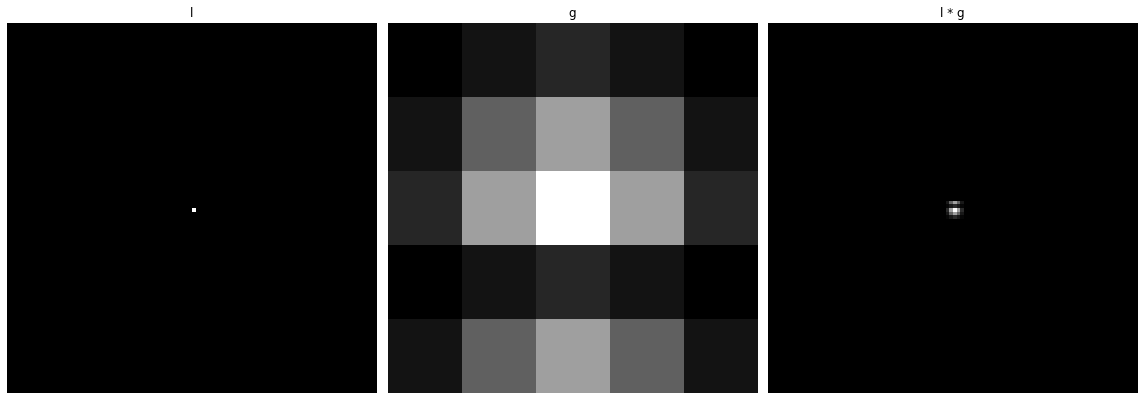

In [16]:
l = np.zeros((100, 100))
l[50][50] = 255

g = np.array([[1/273, 4/273, 7/273, 4/273, 1/273],
               [4/273, 16/273, 26/273, 16/273, 4/273],
               [7/273, 26/273, 41/273, 26/273, 7/273],
               [1/273, 4/273, 7/273, 4/273, 1/273],
               [4/273, 16/273, 26/273, 16/273, 4/273]])

filtered_img = apply_filter(l, g)
display_images([l, g, filtered_img], ['l', 'g', 'l * g'])

# Questao 5

Pesquise e implemente um filtro para remocao de ruıdos que nao possa ser representado com convolucoes.

In [17]:
# filtro da mediana

def median_filter(image, window_size):
    height, width = image.shape
    edge = window_size // 2

    # Add padding to the image
    padded_image = np.pad(image, ((edge, edge), (edge, edge)), mode='edge')
    copied_image = padded_image.copy()

    for y in range(edge, height + edge):
        for x in range(edge, width + edge):
            window = padded_image[y - edge:y + edge + 1, x - edge:x + edge + 1]
            copied_image[y, x] = np.median(window)

    # Remove the padding
    copied_image = copied_image[edge:-edge, edge:-edge]
    return copied_image

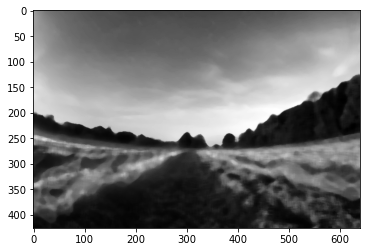

In [18]:
img = read_ppm('./grayscale-sample.ppm')
result = median_filter(img, 9)
plt.imshow(result, cmap='gray')
plt.show()

# Questao 6

Aplique o detector de canny usando a funcao Canny() da OpenCV em uma ou mais imagens de sua escolha. Experimente variar cada um dos parametros threshold1, threshold2 e apertureSize. Explique com suas palavras a influencia de cada parametro no resultado.

In [19]:
import cv2
print(cv2.__version__)

img = cv2.imread('lena.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Vary the parameters for edge detection
threshold1_values = [50, 100, 150]
threshold2_values = [100, 150, 200]
aperture_values = [3, 5, 7]

# Create subplots
fig, axs = plt.subplots(len(threshold1_values), len(threshold2_values) * len(aperture_values), 
                        figsize=(22, 8))

# Iterate through parameter combinations
for i, threshold1 in enumerate(threshold1_values):
    for j, threshold2 in enumerate(threshold2_values):
        for k, aperture_size in enumerate(aperture_values):
            # Apply Canny edge detection
            edges = cv2.Canny(gray, threshold1, threshold2, apertureSize=aperture_size)

            # Display the results
            axs[i, j * len(aperture_values) + k].imshow(edges, cmap='gray')
            axs[i, j * len(aperture_values) + k].set_title(f'T1={threshold1}, T2={threshold2}, AS={aperture_size}')
            axs[i, j * len(aperture_values) + k].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

TypeError: 'numpy._DTypeMeta' object is not subscriptable

O threshold1 é o menor limiar, o que significa que qualquer gradiente abaixo dele não será considerado borda. Assim, aumentá-lo fará com que o detector de Canny rejeite mais bordas. Já o threshold2 é o limiar maior; os gradientes serão aceitos como bordas se forem maiores que ele, de modo que aumentá-lo fará com que o detector de Canny encontre menos bordas.

Aumentar o threshold2 significa que para ser considerado borda o gradiente precisa ser muito intenso. Já aumentar o threshold1 trará maior rejeição de bordas.

Aumentar apertureSize pode ajudar a suavizar o ruído, mas também pode fazer com que o detector de Canny perca bordas finas, já que vai estar considerando uma janela maior ao calcular os gradientes.


# Questao 7

Escolha uma imagem interessante e gere uma piramide aplicando sucessivamente downsampling 3 vezes com fator 1/2. Faca o mesmo com uma piramide gaussiana e compare os resultados. Mostre os resultados de cada piramide em uma  ́unica imagem lado a lado, como no slides 20 (vai exigir algumas operacoes de translacao de imagens). Obs.: aqui voce pode usar funcoes do OpenCV.

In [20]:
def generate_pyramid_resize(img, levels=4):
    height, width, color = img.shape
    hh, ww = height, width

    pyramid = [img.copy()]

    output = np.zeros((height, width + (width // 2), 3), dtype=np.uint8)
    output[0:height, 0:width, :color] = pyramid[0]

    yoffset = 0
    xoffset = width
    for i in range(1, levels):
        downsampled = cv2.resize(pyramid[i-1], (hh // 2, ww // 2))
        hh, ww = downsampled.shape[:2]
        pyramid.append(downsampled)
        output[ yoffset:yoffset+hh, xoffset:xoffset+ww ] = downsampled
        yoffset += hh
    return output


def generate_pyramid_gauss(img, levels=4):
    height, width, color = img.shape

    pyramid = [img.copy()]

    output = np.zeros((height, width + (width // 2), 3), dtype=np.uint8)
    output[0:height, 0:width, :color] = pyramid[0]

    yoffset = 0
    xoffset = width
    for i in range(1, levels):
        downsampled = cv2.pyrDown(pyramid[i-1])
        hh, ww = downsampled.shape[:2]
        pyramid.append(downsampled)
        output[ yoffset:yoffset+hh, xoffset:xoffset+ww ] = downsampled
        yoffset += hh
    return output



img = cv2.imread("lena.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gaussian = generate_pyramid_gauss(img)
resized = generate_pyramid_resize(img)

display_imgs([gaussian, resized], ['Pirâmide Gaussiana', 'Resized'])

NameError: name 'cv2' is not defined

# Questao 8

Usando a funcao da questao 1, crie funcoes que apliquem filtros para calcular as imagens representando ∂f∂x ,
∂f∂y e |∇f|. Em seguida, implemente o operador de Sobel usando estas imagens como entrada. Exiba cada um desses resultados para tres imagens distintas.

In [21]:
def compute_partial_derivative_x(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return apply_filter(img, sobel_x)

def compute_partial_derivative_y(img):
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    return apply_filter(img, sobel_y)

def compute_gradient_magnitude(img):
    partial_derivative_x = compute_partial_derivative_x(img)
    partial_derivative_y = compute_partial_derivative_y(img)
    return np.sqrt(partial_derivative_x**2 + partial_derivative_y**2)

def sobel_operator(img):
    return compute_gradient_magnitude(img)

In [22]:
img1 = read_ppm('./grayscale-sample.ppm')
img2 = read_ppm('./grayscale-lena.ppm')
img3 = read_ppm('./grayscale-dwsample.ppm')

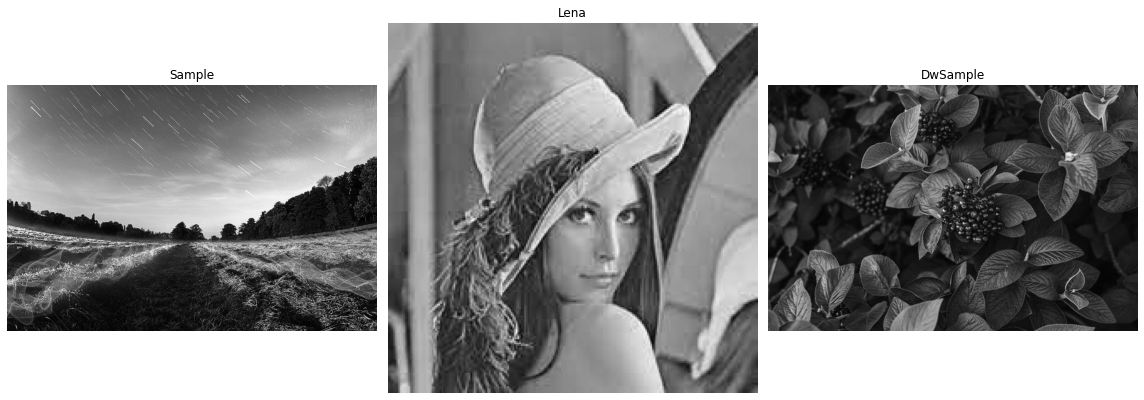

In [23]:
display_images([img1, img2, img3], ['Sample', 'Lena', 'DwSample'])

In [25]:
partial_derivative_x_img1 = compute_partial_derivative_x(img1)
partial_derivative_y_img1 = compute_partial_derivative_y(img1)
gradient_magnitude_img1 = compute_gradient_magnitude(img1)

partial_derivative_x_img2 = compute_partial_derivative_x(img2)
partial_derivative_y_img2 = compute_partial_derivative_y(img2)
gradient_magnitude_img2 = compute_gradient_magnitude(img2)

partial_derivative_x_img3 = compute_partial_derivative_x(img3)
partial_derivative_y_img3 = compute_partial_derivative_y(img3)
gradient_magnitude_img3 = compute_gradient_magnitude(img3)

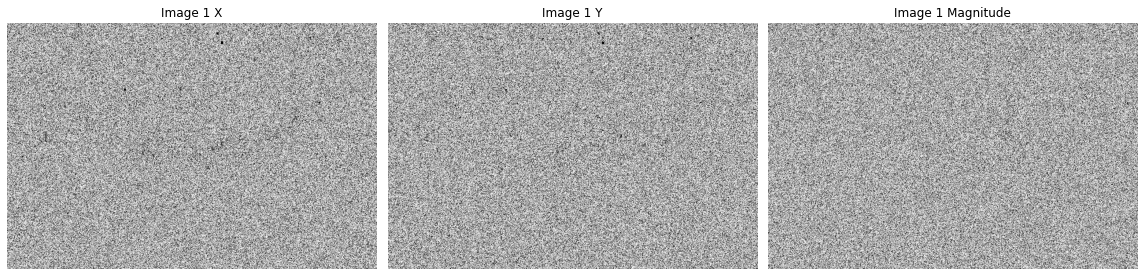

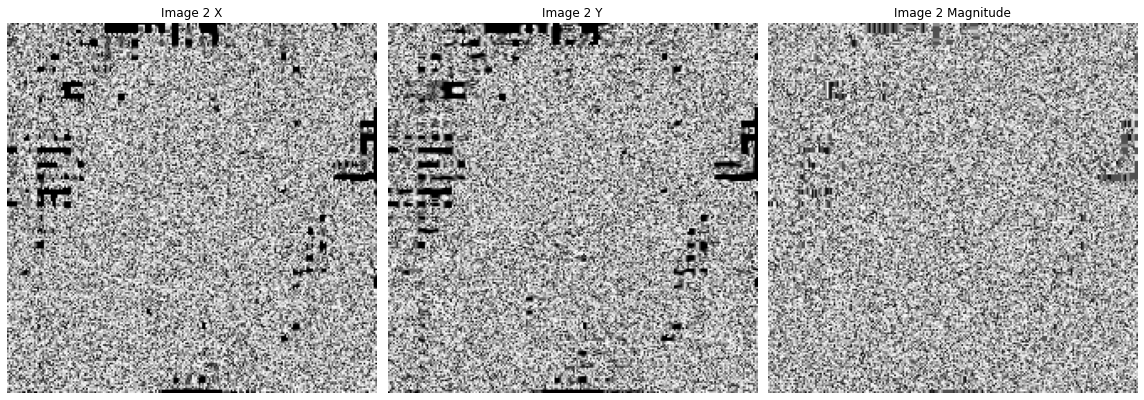

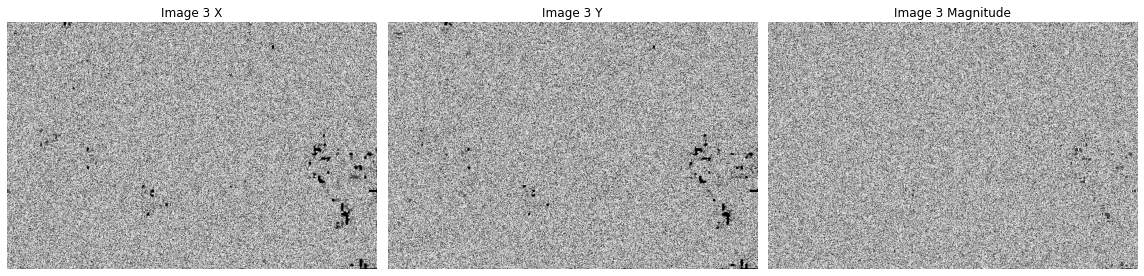

In [26]:
sobel_img1_x = sobel_operator(partial_derivative_x_img1)
sobel_img1_y = sobel_operator(partial_derivative_y_img1)
sobel_img1_magnitude = sobel_operator(gradient_magnitude_img1)

sobel_img2_x = sobel_operator(partial_derivative_x_img2)
sobel_img2_y = sobel_operator(partial_derivative_y_img2)
sobel_img2_magnitude = sobel_operator(gradient_magnitude_img2)

sobel_img3_x = sobel_operator(partial_derivative_x_img3)
sobel_img3_y = sobel_operator(partial_derivative_y_img3)
sobel_img3_magnitude = sobel_operator(gradient_magnitude_img3)

display_images([sobel_img1_x, sobel_img1_y, sobel_img1_magnitude], ['Image 1 X', 'Image 1 Y', 'Image 1 Magnitude'])
display_images([sobel_img2_x, sobel_img2_y, sobel_img2_magnitude], ['Image 2 X', 'Image 2 Y', 'Image 2 Magnitude'])
display_images([sobel_img3_x, sobel_img3_y, sobel_img3_magnitude], ['Image 3 X', 'Image 3 Y', 'Image 3 Magnitude'])